In [1]:
#world population subdivided into 3 categories: #Infectious #Suceptible #Removed

In [2]:
#notes:
#we assume all actions happen at the end of the day (movement, getting removed, etc) (after possibly infecting people)

In [1]:
#Constant factors to mesure variation:
cnst_SD = 0.5
cnst_hyg = 0.5
cnst_RH = 0.1
cnst_T = 20
cnst_probrem = 0.5
cnst_pop = 50
cnst_maxdaysrem = 10
cnst_worldsizex = 10
cnst_worldsizey = 10

In [2]:
def find_neighbors(current, worldmap):
    max_x, max_y = worldmap.shape
    x = current[0]
    y = current[1]
    neighbors = []
    left = [int(x),int(y-1)]
    right = [int(x),int(y+1)]
    up = [int(x-1),int(y)]
    down = [int(x+1),int(y)]
    topleft = [int(x-1),int(y-1)]
    topright = [int(x-1),int(y+1)]
    botleft = [int(x+1),int(y-1)]
    botright = [int(x+1),int(y+1)]
    
    
    if x > 0:
        neighbors.append(up)
    if x < max_x-1:
        neighbors.append(down)
    if y > 0:
        neighbors.append(left)
    if y < max_y-1:
        neighbors.append(right)
    if x > 0 and y > 0:
        neighbors.append(topleft)
    if x > 0 and y < max_y-1:
        neighbors.append(topright)
    if x < max_x-1 and y > 0:
        neighbors.append(botleft)
    if x < max_x-1 and y < max_y-1:
        neighbors.append(botright)
        
    return neighbors

In [3]:
def find_number_infected(infected):
    number_infected = 0
    for i in range(len(infected)):
        number_infected += 1
    return number_infected  

In [4]:
def find_number_removed(removed):
    number_removed = 0
    for i in range(len(removed)):
        number_removed += 1
    return number_removed

In [5]:
def find_prob_inf(hygiene,relative_humidity,temperature):
    
    temp_impact = 1 - temperature/30
    RH_impact = 1 - ((relative_humidity-0.2)/0.6)
    
    if temp_impact <= 0:
        temp_impact = 0
    if RH_impact <= 0:
        RH_impact = 0
    if RH_impact >= 1:
        RH_impact = 1
    
    probinf = (1-hygiene)*temp_impact*RH_impact
    return probinf
    

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def simulate(social_distancing_factor, hygiene, relative_humidity, temperature, probrem, population, maxdaysrem, cnst_worldsizex, cnst_worldsizey):
    
    worldsizex = cnst_worldsizex
    worldsizey = cnst_worldsizey
    nb_sim = 1000
    totaldays = 0
    totalrem = 0
    
    for i in range(nb_sim):
        

        probinf = find_prob_inf(hygiene, relative_humidity, temperature)
        worldmap = np.zeros((worldsizex,worldsizey)) #creating the worldmap
        individuals = np.zeros(population) # 0 = suceptible ; 1 = infectious
        placeindiv = np.zeros((population,2))
        x = np.random.randint(0,population-1,1) #first infected
        individuals[int(x)] = 1

        i = 1
        while i <= population:   #randomly place everyone on map
            x = np.random.randint(0,worldsizex,1)
            y = np.random.randint(0,worldsizey,1)

            if worldmap[x,y] == 0:  
                worldmap[x,y] = i
                placeindiv[(i-1),0] = x
                placeindiv[i-1,1] = y
                i += 1

#creating an array for the time it takes for a person to develop symptoms and time for the virus to be lethal

        daysrem = np.zeros(population)
        for i in range(len(daysrem)):
            daysrem[i] = np.random.randint(0,maxdaysrem,1)

        import random

#initiating some variables

        max_days = 100
        day = 1
        infected = [-1]
        newinfected = []
        daysinfected=np.zeros(population)

        removed = []
        newremoved = []



        while day <= max_days and len(infected) > 0: #continue while people are still infected


            if infected[0]== -1:
                infected.clear()



#making a list of all infected poeple at the start of the day

            for x in range(len(individuals)): 
                if individuals[x] == 1:
                    if x not in infected and x not in removed:
                        infected.append(x)

#create an array for how many days has a person been infected

            for i in infected:
                daysinfected[i] += 1


#creating a list of all poeple infected during that day

            for y in infected:
                neighbors = find_neighbors(placeindiv[y],worldmap)
                for neighbor in neighbors:
                    if worldmap[neighbor[0],neighbor[1]] != 0:
                        pers = int(worldmap[neighbor[0],neighbor[1]])-1
                        if np.random.uniform(0,1) <= probinf: #probability of getting infected
                            if pers not in newinfected and pers not in infected and pers not in removed:
                                newinfected.append(pers)


#creating a list of all removed poeple (dead, recovered, quarantined)

            for x in infected:
                if x not in removed: 
                    if np.random.uniform(0,1) <= probrem and daysinfected[x] >= daysrem[x]: #
                        newremoved.append(x)
                        worldmap[int(placeindiv[x,0]),int(placeindiv[x,1])] = 0

            for x in range(len(newremoved)):
                infected.remove(newremoved[x])

#adding the newly infected poeple to the list of infected poeple (day reset)

            for z in newinfected:
                infected.append(z)


            for z in newremoved:
                removed.append(z)


#print("infected end day",infected)


            newremoved.clear()
            newinfected.clear()

            #make people move at end of the day
            worldmap = move_people(worldmap,social_distancing_factor, individuals, placeindiv, removed)
            
            day += 1
            
        totaldays += day-1
        totalrem += find_number_removed(removed)

    data = [totaldays/nb_sim, totalrem/nb_sim]
    return data

In [32]:
#move people randomly one square around them

import random

def move_people(worldmap,social_distancing_factor, individuals, placeindiv, removed):
    isolated_spots = []
    for x in range(len(individuals)):
        if x not in removed:
            current_position = placeindiv[x] #only move people who arent dead or recovered (only they impact the spread)
        else:
            break

        
        if np.random.uniform(0,1) >= social_distancing_factor: #social distancing factor
            
            neighbors = find_neighbors(placeindiv[x],worldmap)
            neighbor = random.choice(neighbors)
            if worldmap[neighbor[0],neighbor[1]] == 0:
                worldmap[neighbor[0],neighbor[1]] = x+1
                worldmap[int(current_position[0]),int(current_position[1])] = 0
                placeindiv[x,0] = neighbor[0]
                placeindiv[x,1] = neighbor[1]
                
        else: #case of social distancing
            
            neighbors = find_neighbors(placeindiv[x],worldmap)
            
            for neighbor in neighbors:
                count = 0
                second_neighbors = find_neighbors(neighbor,worldmap)
                
                for second_neighbor in second_neighbors:
                    if worldmap[second_neighbor[0],second_neighbor[1]]==0:
                        count += 1
                if count == (len(second_neighbors)-1) and worldmap[neighbor[0],neighbor[1]] == 0:
                    isolated_spots.append(neighbor) #all isolated spots with no one in them
                        
                        
            
            #moving the person to a free isolated spot
            if len(isolated_spots) !=0:
                randchoice = random.choice(isolated_spots)
                worldmap[randchoice[0],randchoice[1]] = x+1
                worldmap[int(current_position[0]),int(current_position[1])] = 0
                placeindiv[x,0] = randchoice[0]
                placeindiv[x,1] = randchoice[1]
            
                
            isolated_spots.clear()    
                    
            
            

    return worldmap

Effect of social distancing
SD_factor: 0.1 average length of virus: 24.641 days. proportion of removed 42.87 %
SD_factor: 0.2 average length of virus: 24.106 days. proportion of removed 41.501999999999995 %
SD_factor: 0.3 average length of virus: 23.664 days. proportion of removed 40.014 %
SD_factor: 0.4 average length of virus: 22.743 days. proportion of removed 36.734 %
SD_factor: 0.5 average length of virus: 22.607 days. proportion of removed 36.01 %
SD_factor: 0.6 average length of virus: 21.824 days. proportion of removed 33.7 %
SD_factor: 0.7 average length of virus: 20.862 days. proportion of removed 31.053999999999995 %
SD_factor: 0.8 average length of virus: 20.774 days. proportion of removed 29.774 %
SD_factor: 0.9 average length of virus: 19.952 days. proportion of removed 27.312 %
SD_factor: 1.0 average length of virus: 17.729 days. proportion of removed 23.124000000000002 %


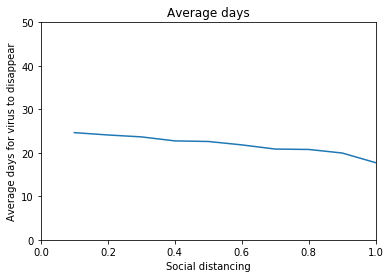

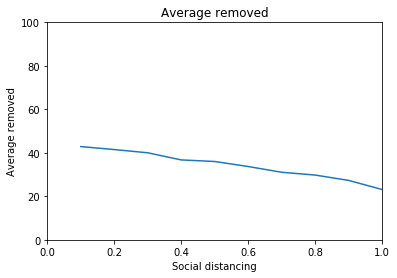

In [33]:
#effect of social distancing

SD_factors = [0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 1.0]
average_days_SD = []
average_removed_SD = []
print("Effect of social distancing")
for i in SD_factors:
    data = simulate(i, cnst_hyg, cnst_RH, cnst_T, cnst_probrem, cnst_pop, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_SD.append(data[0])
    average_removed_SD.append(100*data[1]/cnst_pop)
    print ("SD_factor:", i, "average length of virus:", average_days_SD[-1],"days.", "proportion of removed", average_removed_SD[-1],"%")
    
plt.plot(SD_factors, average_days_SD)
plt.title('Average days')
plt.xlabel('Social distancing')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 1, 0, 50])
plt.show()

plt.plot(SD_factors, average_removed_SD)
plt.title('Average removed')
plt.xlabel('Social distancing')
plt.ylabel('Average removed')
plt.axis([0, 1, 0, 100])
plt.show()

Effect of hygiene
Hygene factor: 0.1 average length of virus: 25.043 days. proportion of removed 62.75 %
Hygene factor: 0.2 average length of virus: 25.156 days. proportion of removed 57.3 %
Hygene factor: 0.3 average length of virus: 24.884 days. proportion of removed 51.354 %
Hygene factor: 0.4 average length of virus: 23.672 days. proportion of removed 42.364 %
Hygene factor: 0.5 average length of virus: 21.484 days. proportion of removed 34.486 %
Hygene factor: 0.6 average length of virus: 19.862 days. proportion of removed 26.007999999999996 %
Hygene factor: 0.7 average length of virus: 16.239 days. proportion of removed 16.358 %
Hygene factor: 0.8 average length of virus: 12.483 days. proportion of removed 9.382 %
Hygene factor: 0.9 average length of virus: 8.074 days. proportion of removed 4.064 %
Hygene factor: 1.0 average length of virus: 5.763 days. proportion of removed 2.0 %


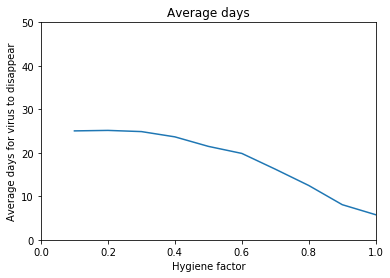

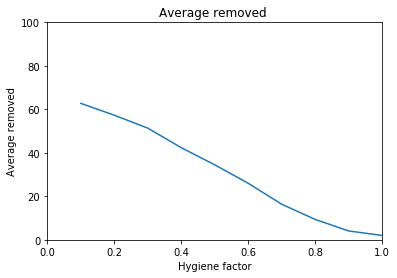

In [34]:
#effect of hygiene

Hyg_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
average_days_hyg = []
average_removed_hyg = []

print("Effect of hygiene")
for i in Hyg_factors:
    data = simulate(cnst_SD, i, cnst_RH, cnst_T, cnst_probrem, cnst_pop, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_hyg.append(data[0])
    average_removed_hyg.append(100*data[1]/cnst_pop)
    print("Hygene factor:", i, "average length of virus:", average_days_hyg[-1],"days.", "proportion of removed", average_removed_hyg[-1],"%")
    
plt.plot(Hyg_factors, average_days_hyg)
plt.title('Average days')
plt.xlabel('Hygiene factor')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 1, 0, 50])
plt.show()

plt.plot(Hyg_factors, average_removed_hyg)
plt.title('Average removed ')
plt.xlabel('Hygiene factor')
plt.ylabel('Average removed')
plt.axis([0, 1, 0, 100])
plt.show()

Effect of relative humidity
Relative humidity factor: 0.1 average length of virus: 22.165 days. proportion of removed 34.93 %
Relative humidity factor: 0.2 average length of virus: 22.227 days. proportion of removed 35.728 %
Relative humidity factor: 0.3 average length of virus: 20.323 days. proportion of removed 28.055999999999997 %
Relative humidity factor: 0.4 average length of virus: 17.8 days. proportion of removed 19.646 %
Relative humidity factor: 0.5 average length of virus: 14.026 days. proportion of removed 12.6 %
Relative humidity factor: 0.6 average length of virus: 10.456 days. proportion of removed 7.112 %
Relative humidity factor: 0.7 average length of virus: 7.506 days. proportion of removed 3.466 %
Relative humidity factor: 0.8 average length of virus: 5.487 days. proportion of removed 2.0 %
Relative humidity factor: 0.9 average length of virus: 5.65 days. proportion of removed 2.0 %
Relative humidity factor: 1.0 average length of virus: 5.599 days. proportion of remov

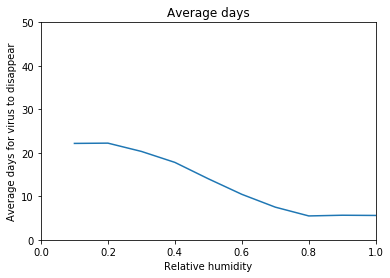

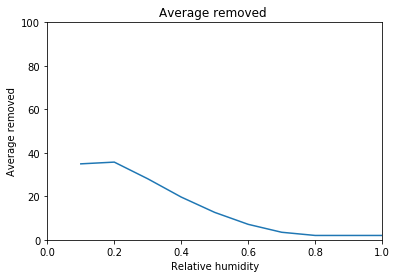

In [35]:
#effect of relative humidity

RH_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
average_days_RH = []
average_removed_RH = []

print("Effect of relative humidity")
for i in RH_factors:
    data = simulate(cnst_SD, cnst_hyg, i, cnst_T, cnst_probrem, cnst_pop, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_RH.append(data[0])
    average_removed_RH.append(100*data[1]/cnst_pop)
    print("Relative humidity factor:", i, "average length of virus:", average_days_RH[-1],"days.", "proportion of removed", average_removed_RH[-1],"%")
    
plt.plot(RH_factors, average_days_RH)
plt.title('Average days')
plt.xlabel('Relative humidity')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 1, 0, 50])
plt.show()

plt.plot(RH_factors, average_removed_RH)
plt.title('Average removed ')
plt.xlabel('Relative humidity')
plt.ylabel('Average removed')
plt.axis([0, 1, 0, 100])
plt.show()

Effect of temperature
Temperature factor: 0 average length of virus: 23.514 days. proportion of removed 79.878 %
Temperature factor: 3 average length of virus: 24.171 days. proportion of removed 77.342 %
Temperature factor: 6 average length of virus: 24.716 days. proportion of removed 73.3 %
Temperature factor: 9 average length of virus: 25.142 days. proportion of removed 67.876 %
Temperature factor: 12 average length of virus: 25.051 days. proportion of removed 61.681999999999995 %
Temperature factor: 15 average length of virus: 24.87 days. proportion of removed 54.122 %
Temperature factor: 18 average length of virus: 24.337 days. proportion of removed 45.13 %
Temperature factor: 21 average length of virus: 21.234 days. proportion of removed 31.108 %
Temperature factor: 24 average length of virus: 16.114 days. proportion of removed 16.758 %
Temperature factor: 27 average length of virus: 10.162 days. proportion of removed 6.382 %
Temperature factor: 30 average length of virus: 5.569 d

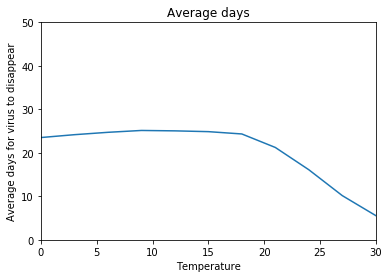

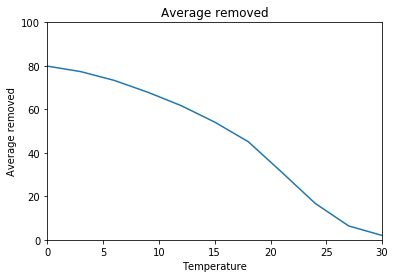

In [39]:
#effect of Temperature

Temp_factors = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
average_days_Temp = []
average_removed_Temp = []

print("Effect of temperature")
for i in Temp_factors:
    data = simulate(cnst_SD, cnst_hyg, cnst_RH, i, cnst_probrem, cnst_pop, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_Temp.append(data[0])
    average_removed_Temp.append(100*data[1]/cnst_pop)
    print("Temperature factor:", i, "average length of virus:", average_days_Temp[-1],"days.", "proportion of removed", average_removed_Temp[-1],"%")
    
plt.plot(Temp_factors, average_days_Temp)
plt.title('Average days')
plt.xlabel('Temperature')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 30, 0, 50])
plt.show()

plt.plot(Temp_factors, average_removed_Temp)
plt.title('Average removed')
plt.xlabel('Temperature')
plt.ylabel('Average removed')
plt.axis([0, 30, 0, 100])
plt.show()

Effect of the probability of being removed
prob. removed factor: 0.1 average length of virus: 62.044 days. proportion of removed 74.738 %
prob. removed factor: 0.2 average length of virus: 38.906 days. proportion of removed 57.22 %
prob. removed factor: 0.3 average length of virus: 29.868 days. proportion of removed 46.318000000000005 %
prob. removed factor: 0.4 average length of virus: 25.381 days. proportion of removed 41.304 %
prob. removed factor: 0.5 average length of virus: 22.899 days. proportion of removed 36.356 %
prob. removed factor: 0.6 average length of virus: 20.13 days. proportion of removed 32.052 %
prob. removed factor: 0.7 average length of virus: 19.126 days. proportion of removed 29.688 %
prob. removed factor: 0.8 average length of virus: 17.672 days. proportion of removed 27.842 %
prob. removed factor: 0.9 average length of virus: 16.518 days. proportion of removed 25.74 %
prob. removed factor: 1.0 average length of virus: 16.276 days. proportion of removed 24.89 %

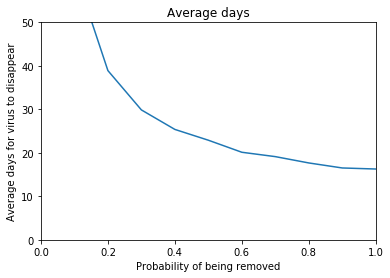

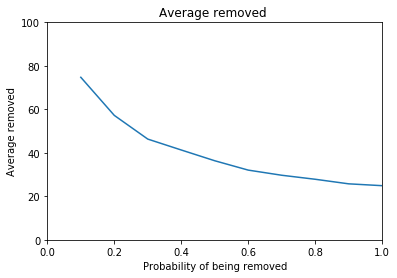

In [40]:
#effect of probability of being removed on a given day (probability of dying on a given day + probability of recovering on a given day)

probrem_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
average_days_probrem = []
average_removed_probrem = []

print("Effect of the probability of being removed")
for i in probrem_factors:
    data = simulate(cnst_SD, cnst_hyg, cnst_RH, cnst_T, i, cnst_pop, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_probrem.append(data[0])
    average_removed_probrem.append(100*data[1]/cnst_pop)
    print("prob. removed factor:", i, "average length of virus:", average_days_probrem[-1],"days.", "proportion of removed", average_removed_probrem[-1],"%")
    
plt.plot(probrem_factors, average_days_probrem)
plt.title('Average days')
plt.xlabel('Probability of being removed')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 1, 0, 50])
plt.show()

plt.plot(probrem_factors, average_removed_probrem)
plt.title('Average removed ')
plt.xlabel('Probability of being removed')
plt.ylabel('Average removed')
plt.axis([0, 1, 0, 100])
plt.show()

Effect of the time one is infectious but not showing symptoms
max days factor: 1 average length of virus: 4.491 days. proportion of removed 7.406000000000001 %
max days factor: 2 average length of virus: 4.539 days. proportion of removed 7.604 %
max days factor: 3 average length of virus: 5.704 days. proportion of removed 9.36 %
max days factor: 4 average length of virus: 7.729 days. proportion of removed 12.162 %
max days factor: 5 average length of virus: 9.832 days. proportion of removed 16.258 %
max days factor: 6 average length of virus: 12.447 days. proportion of removed 20.056 %
max days factor: 7 average length of virus: 14.416 days. proportion of removed 22.81 %
max days factor: 8 average length of virus: 17.021 days. proportion of removed 27.324 %
max days factor: 9 average length of virus: 19.033 days. proportion of removed 30.358 %
max days factor: 10 average length of virus: 22.526 days. proportion of removed 36.182 %


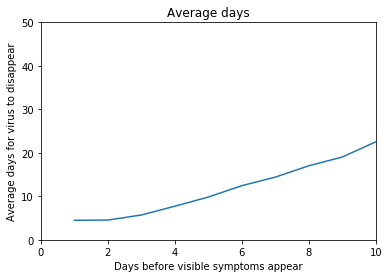

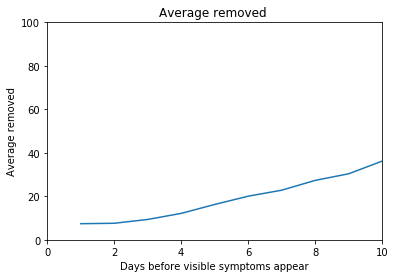

In [41]:
#effect of how long someone is infectious but not showing symptoms (staying in the population)

maxdaysrem_factors = [1, 2, 3, 4, 5 ,6 , 7, 8, 9, 10]
average_days_maxdaysrem = []
average_removed_maxdaysrem = []

print("Effect of the time one is infectious but not showing symptoms")
for i in maxdaysrem_factors:
    data = simulate(cnst_SD, cnst_hyg, cnst_RH, cnst_T, cnst_probrem, cnst_pop, i, cnst_worldsizex, cnst_worldsizey)
    average_days_maxdaysrem.append(data[0])
    average_removed_maxdaysrem.append(100*data[1]/cnst_pop)
    print("max days factor:", i, "average length of virus:", average_days_maxdaysrem[-1],"days.", "proportion of removed", average_removed_maxdaysrem[-1],"%")
    
plt.plot(maxdaysrem_factors, average_days_maxdaysrem)
plt.title('Average days')
plt.xlabel('Days before visible symptoms appear')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 10, 0, 50])
plt.show()

plt.plot(maxdaysrem_factors, average_removed_maxdaysrem)
plt.title('Average removed ')
plt.xlabel('Days before visible symptoms appear')
plt.ylabel('Average removed')
plt.axis([0, 10, 0, 100])
plt.show()

Effect of population density
population per 100 m^2: 10 average length of virus: 6.625 days. proportion of removed 13.85 %
population per 100 m^2: 20 average length of virus: 8.145 days. proportion of removed 10.805 %
population per 100 m^2: 30 average length of virus: 11.395 days. proportion of removed 13.610000000000001 %
population per 100 m^2: 40 average length of virus: 16.337 days. proportion of removed 22.2275 %
population per 100 m^2: 50 average length of virus: 21.985 days. proportion of removed 34.036 %
population per 100 m^2: 60 average length of virus: 27.979 days. proportion of removed 51.68333333333333 %
population per 100 m^2: 70 average length of virus: 32.806 days. proportion of removed 71.96 %
population per 100 m^2: 80 average length of virus: 33.985 days. proportion of removed 85.51375 %
population per 100 m^2: 90 average length of virus: 31.55 days. proportion of removed 90.40111111111112 %


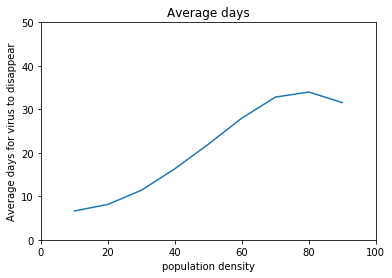

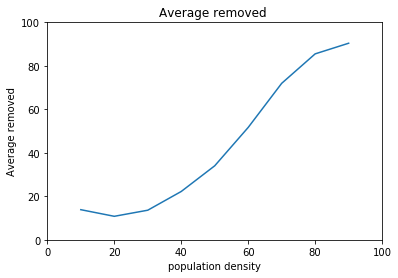

In [42]:
#effect of population (for a world map of 100m^2)

pop_factors = [10, 20, 30, 40, 50, 60, 70, 80, 90]
average_days_pop = []
average_removed_pop = []

print("Effect of population density")
for i in pop_factors:
    data = simulate(cnst_SD, cnst_hyg, cnst_RH, cnst_T, cnst_probrem, i, cnst_maxdaysrem, cnst_worldsizex, cnst_worldsizey)
    average_days_pop.append(data[0])
    average_removed_pop.append(100*data[1]/i)
    print("population per",cnst_worldsizex*cnst_worldsizey, "m^2:", i, "average length of virus:", average_days_pop[-1],"days.", "proportion of removed", average_removed_pop[-1],"%")
    
plt.plot(pop_factors, average_days_pop)
plt.title('Average days')
plt.xlabel('population density')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 100, 0, 50])
plt.show()

plt.plot(pop_factors, average_removed_pop)
plt.title('Average removed ')
plt.xlabel('population density')
plt.ylabel('Average removed')
plt.axis([0, 100, 0, 100])
plt.show()

Effect of the size of the world
For World size:  25 m^2 5 average length of virus: 8.768 days. proportion of removed 34.042857142857144 %
For World size:  100 m^2 10 average length of virus: 11.588 days. proportion of removed 14.616666666666667 %
For World size:  225 m^2 15 average length of virus: 12.182 days. proportion of removed 7.443283582089552 %
For World size:  400 m^2 20 average length of virus: 13.302 days. proportion of removed 4.802499999999999 %
For World size:  625 m^2 25 average length of virus: 13.773 days. proportion of removed 3.5021390374331554 %
For World size:  900 m^2 30 average length of virus: 14.306 days. proportion of removed 2.4685185185185183 %
For World size:  1225 m^2 35 average length of virus: 14.414 days. proportion of removed 1.8024523160762942 %
For World size:  1600 m^2 40 average length of virus: 14.456 days. proportion of removed 1.40375 %


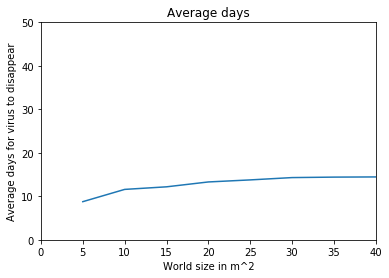

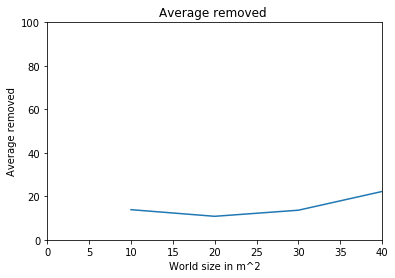

In [43]:
#effect of size of the world (with constant population density of 30%)

WS_factors = [5, 10, 15, 20, 25, 30, 35, 40]
average_days_WS = []
average_removed_WS = []

print("Effect of the size of the world")
for i in WS_factors:
    pop = int(i*i*0.3)
    data = simulate(cnst_SD, cnst_hyg, cnst_RH, cnst_T, cnst_probrem, pop, cnst_maxdaysrem, i, i)
    average_days_WS.append(data[0])
    average_removed_WS.append(100*data[1]/pop)
    print("For World size: ",i*i, "m^2", i, "average length of virus:", average_days_WS[-1],"days.", "proportion of removed", average_removed_WS[-1],"%")
    
plt.plot(WS_factors, average_days_WS)
plt.title('Average days')
plt.xlabel('World size in m^2')
plt.ylabel('Average days for virus to disappear')
plt.axis([0, 40, 0, 50])
plt.show()

plt.plot(pop_factors, average_removed_pop)
plt.title('Average removed ')
plt.xlabel('World size in m^2')
plt.ylabel('Average removed')
plt.axis([0, 40, 0, 100])
plt.show()